In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import keras

from keras import layers
from keras import models
from keras import optimizers, regularizers
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.models import model_from_json
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from collections import Counter

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import scikitplot as skplt




##Loading the Dataset

In [ ]:
(X_train, X_test), (y_train, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (50000, 32, 32, 3)
X_test shape: (50000, 1)
y_train shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
X_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

## Data Analysis

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
Number of training examples: 50000
Number of testing examples: 10000
Number of classes: 10
Image shape: (32, 32, 3)
Image data type: uint8


<BarContainer object of 10 artists>

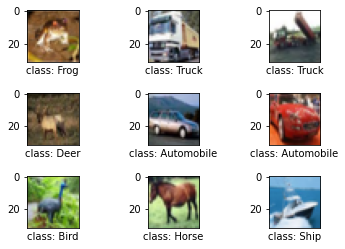

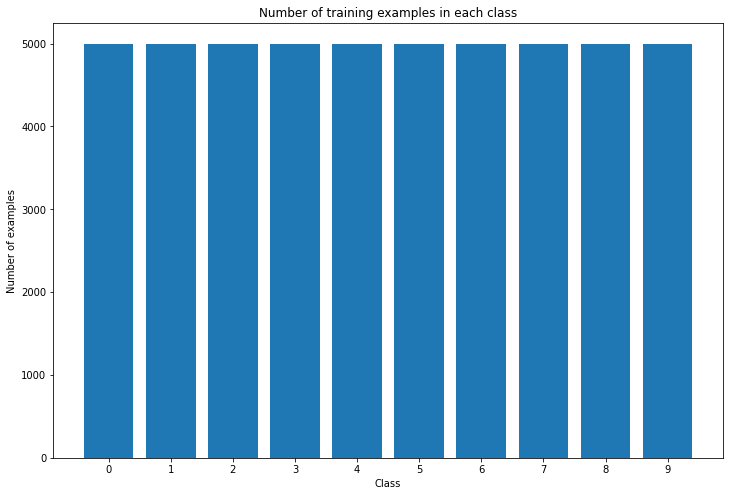

In [ ]:
# Visualize
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

class_to_label =  ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog',
                   'Frog', 'Horse', 'Ship', 'Truck']
print(class_to_label)
for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X_train[i])

    # Name of the true class.
    cls_true_name = class_to_label[X_test[i][0]]
    xlabel = "class: {0}".format(cls_true_name)

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])

num_classes = np.unique(X_test).shape[0]
print("Number of training examples:", X_train.shape[0])
print("Number of testing examples:", y_train.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", X_train[0].shape)
print("Image data type:", X_train.dtype)

reshaped_labels = [class_num[0] for class_num in X_test]
class_distribution = Counter(reshaped_labels)
x = range(10)
y = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of training examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, y)

<BarContainer object of 10 artists>

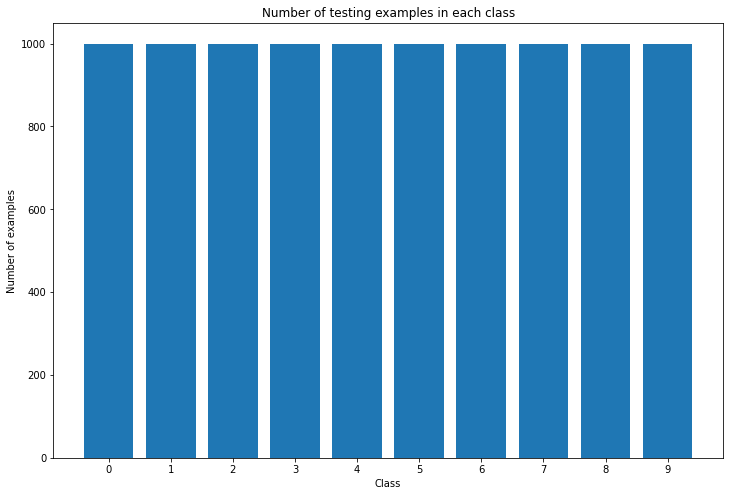

In [ ]:
reshaped_labels = [class_num[0] for class_num in y_test]
class_distribution = Counter(reshaped_labels)
x1 = range(10)
y1 = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of testing examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x1, y1)

In [ ]:
# The class are equally distributed

## Preprocessing the Data

Further, we move on to one hot encoding as the classes are in the character data type and we need it to convert into integer data type for applying it into the models. With the help of this encoding, the number may be converted into a binary vector with 10 elements and an index for the class value of 1. The to_categorical() utility function allows us to accomplish this.

In [ ]:
num_classes = 10
# Convert class vectors to binary class matrices.
X_test = keras.utils.to_categorical(X_test, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Then we perform data augmentation which makes copies of examples in the dataset with small modifications. This has a regularizing effect which can help in performance and we have various augmentations to perform such as rotating the image, shifting the width or height of the image, or flipping the image.

In [ ]:
# Data agumentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

## Normalizing the Data

It is known that each image has been assigned to a value from range 0 to 255, as we are not aware of the best way to scale the values, but we know scaling is needed, so to achieve that the data or values are normalized in the range from 0 to 1. This approach is done by first converting the integer value to float value and then dividing it by 255. Now the data is ready to be implemented on different models.

In [ ]:
# Normalization
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train /= 255
y_train /= 255




# Train weights
def fit_save_model(model, epochs, name=None):
    ''' Fit and save a model, or load from disk '''
    print()
    model.summary()
    if not os.path.isfile('{}.csv'.format(str(name))) or not os.path.isfile('{}.h5'.format(str(name))):
        csv_logger = CSVLogger('{}.csv'.format(str(name)),
                               separator=',',
                               append=False)
        model.fit(X_train, X_test,
                  batch_size=128,
                  epochs=epochs,
                  validation_split = 0.25,
                  callbacks = [csv_logger])
        # serialize weights to HDF5
        model.save_weights('{}.h5'.format(str(name)))
        print('Saved model to disk')
        history = model.history.history
    else:
        log_data = pd.read_csv('{}.csv'.format(str(name)),
                               sep=',',
                               engine='python')
        model.load_weights('{}.h5'.format(str(name)))
        print('Loaded model from disk')
        history = log_data

    test_loss, test_acc = model.evaluate(y_train, y_test)
    print('test_acc:', test_acc)

    return model, history


In [ ]:
X_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

## Modeling

## 1. Applying Simple Model without Convolutional Layer

In [ ]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=X_train.shape[1:]))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 50
model, history = fit_save_model(model, epochs, 'mnist_old3')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               

In [ ]:
score = model.evaluate(y_train, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 43.97%


313/313 [==============================] - 1s 3ms/step - loss: 1.5635 - accuracy: 0.4397
The final loss on the test set is: 1.5635132789611816
The final accuracy on the test set is: 0.43970000743865967


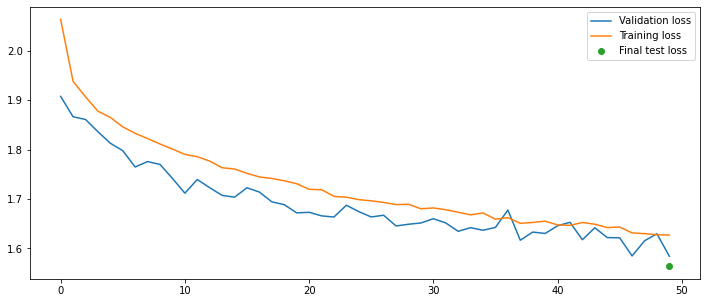

In [ ]:
final_loss, final_accuracy = model.evaluate(y_train, y_test)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()


In [ ]:
def report(model, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    '''
    #test_score = history.decision_function(y_train)
    pred = model.predict(y_train, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(y_test, axis=1),
            predicted)
    probas = model.predict(y_train)
    print(report)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.62      0.33      0.43      1000
           1       0.56      0.58      0.57      1000
           2       0.30      0.19      0.23      1000
           3       0.27      0.40      0.32      1000
           4       0.39      0.34      0.36      1000
           5       0.50      0.23      0.32      1000
           6       0.40      0.63      0.49      1000
           7       0.52      0.47      0.50      1000
           8       0.50      0.67      0.57      1000
           9       0.50      0.55      0.53      1000

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.43     10000
weighted avg       0.45      0.44      0.43     10000



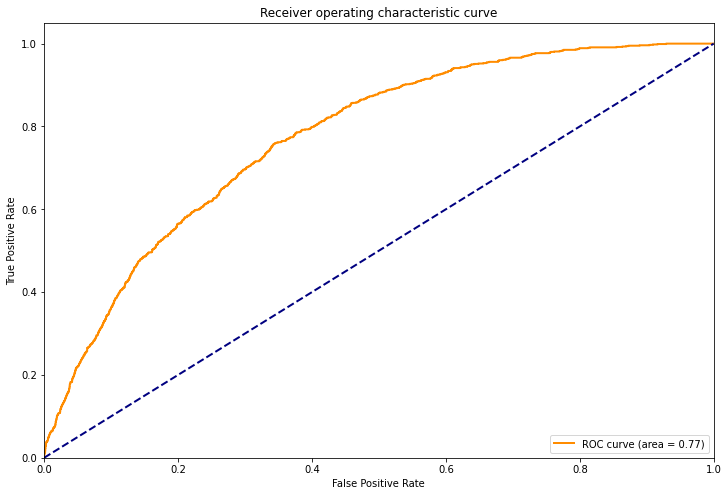

In [ ]:
report(model,epochs)

## 2. Simple Model with convolutional layers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
x = Conv2D(32, (3, 3))
model.add(x)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 100
model, history = fit_save_model(model, epochs, '3')



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
293/293 [==============================] - 11s 17ms/step - loss: 2.1133 - accuracy: 0.2157 - val_loss: 1.9408 - val_accuracy: 0.2965
Epoch 2/100
293/293 [==============================] - 4s 13ms/step - loss: 1.8399 - accuracy: 0.3399 - val_loss: 1.7490 - val_accuracy: 0.3805
Epoch 3/100
293/293 [==============================] - 4s 12ms/step - loss: 1.7168 - accuracy: 0.3802 - val_loss: 1.6598 - val_accuracy: 0.4075
Epoch 4/100
293/293 [==============================] - 4s 13ms/step - loss: 1.6455 - accuracy: 0.4051 - val_loss: 1.5991 - val_accuracy: 0.4261
Epoch 5/100
293/293 [==============================] - 4s 13ms/step - loss: 1.5867 - accuracy: 0.4276 - val_loss: 1.5612 - val_accuracy: 0.4371
Epoch 6/100
293/293 [==============================] - 4s 12ms/step - loss: 1.5424 - accuracy: 0.4421 - val_loss: 1.4939 - val_accuracy: 0.4623
Epoch 7/100
293/293 [==============================] - 4s 13ms/step - loss: 1.4964 - accuracy: 0.4603 - val_loss: 1.4602 - val_accuracy

In [ ]:
score = model.evaluate(y_train, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


accuracy: 73.99%


313/313 [==============================] - 1s 3ms/step - loss: 0.7523 - accuracy: 0.7399
The final loss on the test set is: 0.7522602081298828
The final accuracy on the test set is: 0.7398999929428101


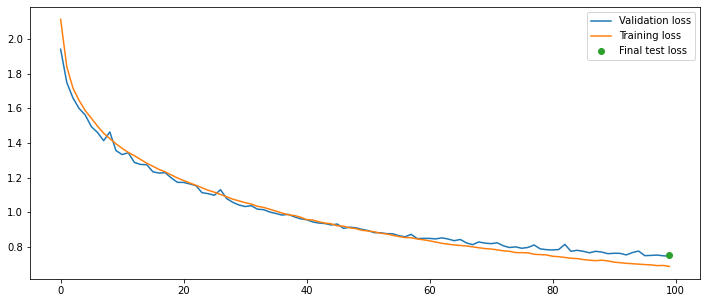

In [ ]:
final_loss, final_accuracy = model.evaluate(y_train, y_test)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

In [ ]:
def report(model, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    '''
    #test_score = history.decision_function(y_train)
    pred = model.predict(y_train, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(y_test, axis=1),
            predicted)
    probas = model.predict(y_train)
    print(report)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.88      0.83      0.86      1000
           2       0.69      0.56      0.62      1000
           3       0.55      0.58      0.56      1000
           4       0.69      0.66      0.68      1000
           5       0.69      0.63      0.65      1000
           6       0.77      0.80      0.79      1000
           7       0.76      0.81      0.78      1000
           8       0.79      0.87      0.83      1000
           9       0.80      0.86      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



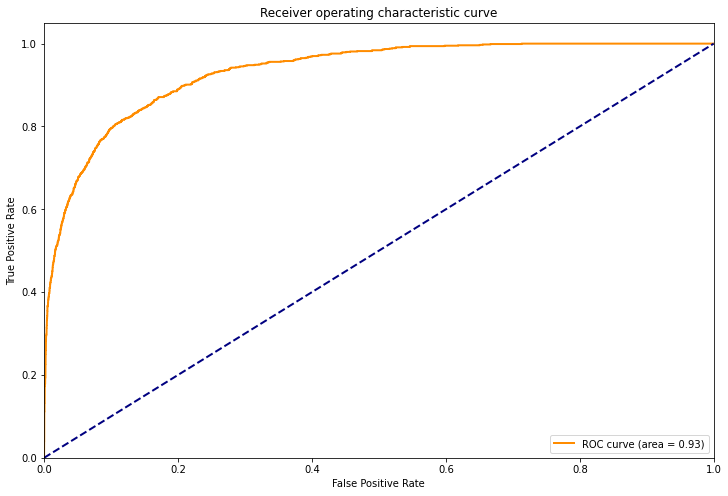

In [ ]:
report(model,epochs)

## 3. Complex Model with Batch Normalization, Kernel Initializer

In [ ]:
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(BatchNormalization())
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.3))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(BatchNormalization())
 model.add(Dropout(0.5))
 model.add(Dense(10, activation='softmax'))




In [ ]:
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100
model, history = fit_save_model(model, epochs, 'nn_1')



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
293/293 [==============================] - 7s 21ms/step - loss: 2.4772 - accuracy: 0.2494 - val_loss: 2.2335 - val_accuracy: 0.2571
Epoch 2/100
293/293 [==============================] - 5s 18ms/step - loss: 1.8301 - accuracy: 0.3579 - val_loss: 1.5709 - val_accuracy: 0.4248
Epoch 3/100
293/293 [==============================] - 5s 18ms/step - loss: 1.6260 - accuracy: 0.4109 - val_loss: 1.5016 - val_accuracy: 0.4451
Epoch 4/100
293/293 [==============================] - 5s 18ms/step - loss: 1.5127 - accuracy: 0.4521 - val_loss: 1.4743 - val_accuracy: 0.4536
Epoch 5/100
293/293 [==============================] - 5s 18ms/step - loss: 1.4370 - accuracy: 0.4761 - val_loss: 1.4477 - val_accuracy: 0.4620
Epoch 6/100
293/293 [==============================] - 5s 18ms/step - loss: 1.3800 - accuracy: 0.5019 - val_loss: 1.4035 - val_accuracy: 0.4800
Epoch 7/100
293/293 [==============================] - 5s 18ms/step - loss: 1.3207 - accuracy: 0.5201 - val_loss: 1.3582 - val_accuracy:

In [ ]:
score = model.evaluate(y_train, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 79.18%


313/313 [==============================] - 1s 4ms/step - loss: 0.6151 - accuracy: 0.7918
The final loss on the test set is: 0.615119993686676
The final accuracy on the test set is: 0.7918000221252441


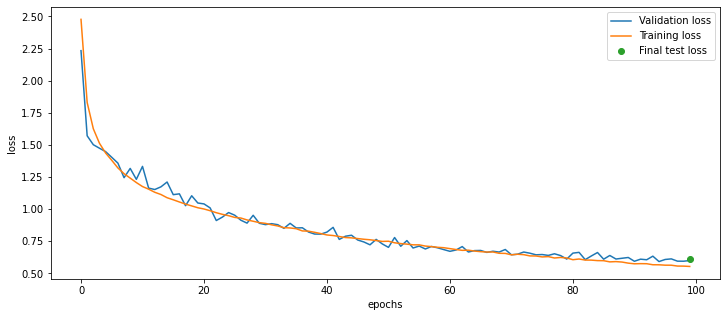

In [ ]:
final_loss, final_accuracy = model.evaluate(y_train, y_test)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
def report(model, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    '''
    #test_score = history.decision_function(y_train)
    pred = model.predict(y_train, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(y_test, axis=1),
            predicted)
    probas = model.predict(y_train)
    print(report)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1000
           1       0.89      0.91      0.90      1000
           2       0.67      0.74      0.70      1000
           3       0.69      0.56      0.62      1000
           4       0.69      0.83      0.76      1000
           5       0.75      0.67      0.71      1000
           6       0.74      0.91      0.82      1000
           7       0.89      0.78      0.83      1000
           8       0.87      0.91      0.89      1000
           9       0.93      0.85      0.89      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



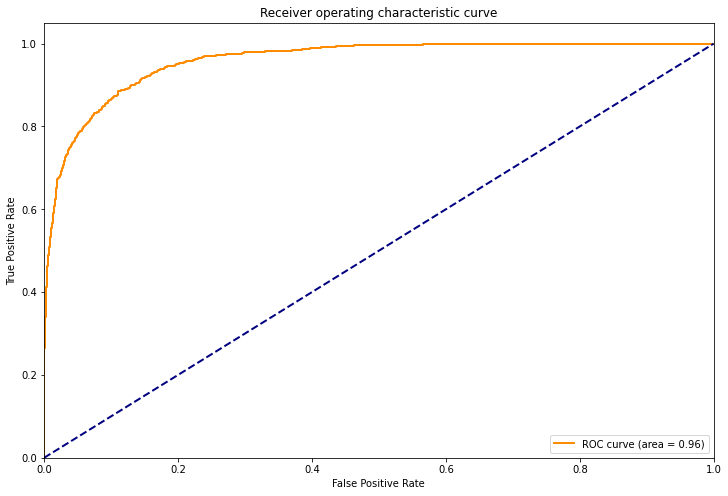

In [ ]:
report(model, epochs)

## 4. Complex CNN model with batch normailzation, data augmentation, L2 Norm regularization

In [ ]:
#Best performing model
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

#compile
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

epochs = 150
model, history = fit_save_model(model, epochs, "best1")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                     

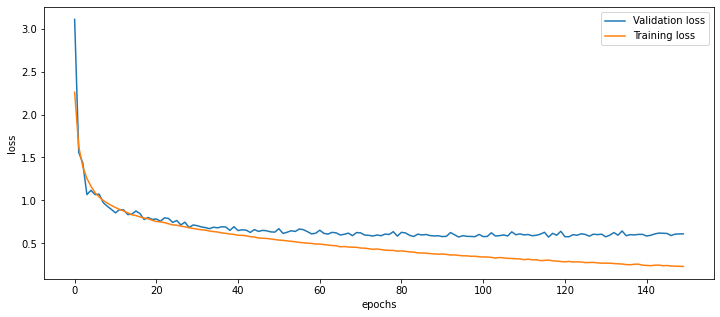

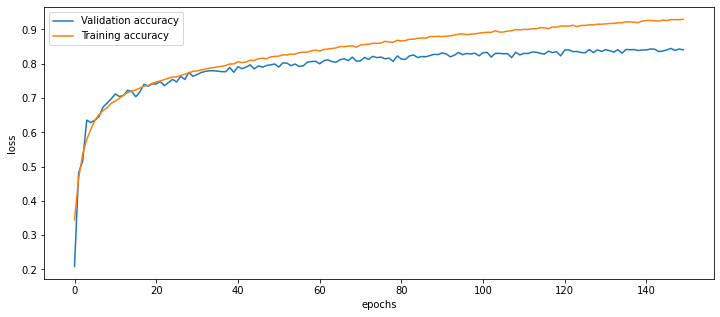

313/313 [==============================] - 1s 4ms/step - loss: 0.6304 - accuracy: 0.8345
The final loss on the test set is: 0.6304400563240051
The final accuracy on the test set is: 0.8345000147819519


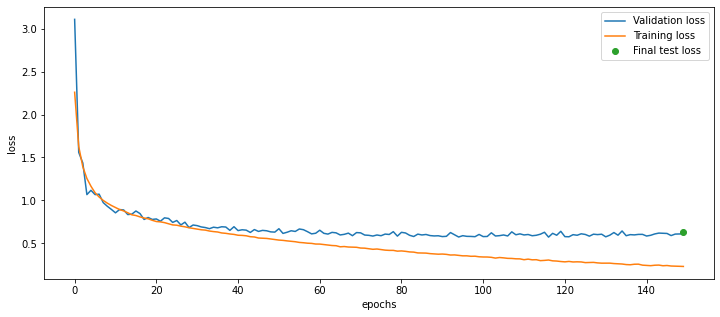

In [ ]:
''' Visulizing losses and acurracy for a model '''
# plotting losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# plotting accuracy
plt.figure(figsize=(12, 5))
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.plot(history['accuracy'], label='Training accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

final_loss, final_accuracy = model.evaluate(y_train, y_test)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plotting final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.94      0.89      0.91      1000
           2       0.82      0.72      0.77      1000
           3       0.74      0.66      0.70      1000
           4       0.80      0.86      0.83      1000
           5       0.77      0.74      0.76      1000
           6       0.85      0.90      0.88      1000
           7       0.85      0.89      0.87      1000
           8       0.84      0.95      0.89      1000
           9       0.87      0.91      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



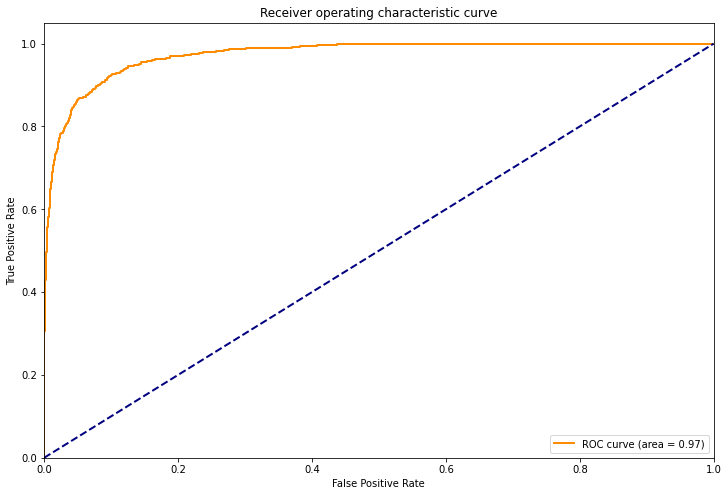

In [ ]:
report(model, epochs)